In [54]:
import pandas as pd
import numpy as np
import re
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

In [55]:
# Fungsi untuk menampilkan nama kolom dari tiap file CSV (cek kolom asli)
def check_columns(paths):
    for path in paths:
        if os.path.exists(path):
            df = pd.read_csv(path, nrows=5)
            print(f"File: {path}")
            print("Kolom tersedia:", df.columns.tolist())
            print("-"*50)
        else:
            print(f"File tidak ditemukan: {path}")

In [56]:
# 1. LOAD MULTIPLE DATASET DENGAN NAMA KOLOM SESUAI INPUT USER
def load_multiple_datasets(files_info):
    dataframes = []
    for info in files_info:
        path = info['path']
        text_col = info['text_col']
        label_col = info['label_col']
        if os.path.exists(path):
            df = pd.read_csv(path)
            if text_col in df.columns and label_col in df.columns:
                df = df[[text_col, label_col]].dropna()
                df[text_col] = df[text_col].astype(str)
                df.rename(columns={text_col: 'Text Tweet', label_col: 'Sentiment'}, inplace=True)
                dataframes.append(df)
            else:
                print(f"Kolom tidak ditemukan di {path}: {text_col}, {label_col}")
        else:
            print(f"File tidak ditemukan: {path}")
    combined_df = pd.concat(dataframes, ignore_index=True)
    return combined_df


In [57]:
# 2. PREPROCESS DATA TRAINING
def preprocess_data(df, max_words=5000, max_len=50):
    tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(df['Text Tweet'])
    sequences = tokenizer.texts_to_sequences(df['Text Tweet'])
    padded = pad_sequences(sequences, maxlen=max_len)

    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(df['Sentiment'])

    return padded, labels, tokenizer, label_encoder

In [58]:

# 3. BANGUN MODEL CNN DENGAN DROPOUT
def build_cnn_model(vocab_size, max_len=50):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [59]:

# 4. PREPROCESS INPUT TEKS SEBELUM PREDIKSI
def preprocess_input_text(texts):
    cleaned_texts = []
    for text in texts:
        text = text.lower()
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        cleaned_texts.append(text)
    return cleaned_texts

In [60]:

# 5. PREDIKSI SENTIMEN
def predict_sentiment(texts, model, tokenizer, label_encoder, max_len=50):
    texts = preprocess_input_text(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=max_len)
    preds = model.predict(padded)
    results = ['positive' if p > 0.5 else 'negative' for p in preds]
    return results

In [61]:

# 6. PREDIKSI INTERAKTIF
def interactive_prediction(model, tokenizer, label_encoder, max_len=50):
    print("Masukkan kalimat untuk prediksi sentimen (ketik 'exit' untuk keluar):")
    while True:
        teks_input = input("> ")
        if teks_input.lower() == 'exit':
            print("Program selesai.")
            break
        hasil = predict_sentiment([teks_input], model, tokenizer, label_encoder, max_len)
        print(f"Hasil prediksi: {hasil[0]}\n")

In [67]:

# === MAIN EXECUTION ===
if __name__ == "__main__":
    dataset_paths = [
        'data/dataset_tweet_sentiment_opini_film.csv',
        'data/dataset_komentar_instagram_cyberbullying.csv',
        'data/dataset_tweet_sentimen_tayangan_tv.csv',
        'data/dataset_tweet_sentiment_cellular_service_provider.csv',
    ]

    # Setelah tahu kolom yang benar, isi sesuai file masing-masing di files_info
    files_info = [
        {'path': 'data/dataset_tweet_sentiment_opini_film.csv', 'text_col': 'Text Tweet', 'label_col': 'Sentiment'},
        {'path': 'data/dataset_komentar_instagram_cyberbullying.csv', 'text_col': 'Instagram Comment Text', 'label_col': 'Sentiment'},
        {'path': 'data/dataset_tweet_sentimen_tayangan_tv.csv', 'text_col': 'Text Tweet', 'label_col': 'Sentiment'},
        {'path': 'data/dataset_tweet_sentiment_cellular_service_provider.csv', 'text_col': 'Text Tweet', 'label_col': 'Sentiment'},
    ]


    df = load_multiple_datasets(files_info)

    X, y, tokenizer, label_encoder = preprocess_data(df, max_words=5000, max_len=50)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    vocab_size = 5000
    cnn_model = build_cnn_model(vocab_size=vocab_size, max_len=50)

    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

    cnn_model.fit(
        X_train, y_train,
        epochs=20,
        validation_data=(X_test, y_test),
        verbose=2,
        callbacks=[early_stopping]
    )


print("=== Cek kolom dataset ===")
check_columns(dataset_paths)
   

Epoch 1/20
33/33 - 3s - 97ms/step - accuracy: 0.5125 - loss: 0.6945 - val_accuracy: 0.6423 - val_loss: 0.6892
Epoch 2/20
33/33 - 1s - 18ms/step - accuracy: 0.5635 - loss: 0.6795 - val_accuracy: 0.5846 - val_loss: 0.6763
Epoch 3/20
33/33 - 1s - 17ms/step - accuracy: 0.7077 - loss: 0.6218 - val_accuracy: 0.7654 - val_loss: 0.6224
Epoch 4/20
33/33 - 1s - 17ms/step - accuracy: 0.8019 - loss: 0.5008 - val_accuracy: 0.8500 - val_loss: 0.4890
Epoch 5/20
33/33 - 1s - 17ms/step - accuracy: 0.9212 - loss: 0.2950 - val_accuracy: 0.8346 - val_loss: 0.3619
Epoch 6/20
33/33 - 1s - 17ms/step - accuracy: 0.9567 - loss: 0.1633 - val_accuracy: 0.8423 - val_loss: 0.3705
Epoch 7/20
33/33 - 1s - 17ms/step - accuracy: 0.9702 - loss: 0.0938 - val_accuracy: 0.8154 - val_loss: 0.4139
=== Cek kolom dataset ===
File: data/dataset_tweet_sentiment_opini_film.csv
Kolom tersedia: ['Id', 'Sentiment', 'Text Tweet']
--------------------------------------------------
File: data/dataset_komentar_instagram_cyberbullying.c

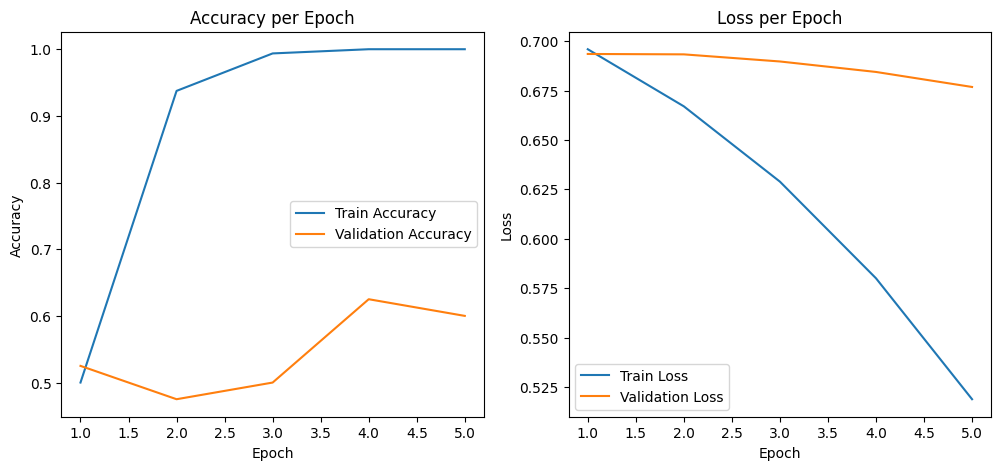

In [68]:
import matplotlib.pyplot as plt

# Contoh data hasil training (ganti sesuai hasil aktual)
epochs = [1, 2, 3, 4, 5]
train_acc = [0.5, 0.9375, 0.9937, 1.0, 1.0]
val_acc = [0.525, 0.475, 0.5, 0.625, 0.6]
train_loss = [0.6959, 0.6670, 0.6289, 0.58, 0.5188]
val_loss = [0.6935, 0.6933, 0.6897, 0.6844, 0.6768]

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
interactive_prediction(cnn_model, tokenizer, label_encoder, max_len=50)

Masukkan kalimat untuk prediksi sentimen (ketik 'exit' untuk keluar):


>  film ini bagus


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Hasil prediksi: positive



>  film ini jelek banget


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Hasil prediksi: negative



>  apaan sih lu


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Hasil prediksi: negative



>  mantap euyyy


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Hasil prediksi: positive

